## OVERVIEW
---
* Image Preprocessing with OpenCV
    * Masking
    * Segmentation
    * Image Sharpening
* Transfer Learning with Keras Pretrained Model
* Feature Extraction
* Deep Learning Model to Classify the Images

In [4]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
import keras
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform
from PIL import Image

from tqdm import tqdm
from glob import glob
import random


from keras.models import Model, Sequential
from keras import models
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking,Flatten
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from keras.preprocessing.image import *
from skimage import io

from sklearn.preprocessing import OneHotEncoder

from datetime import datetime


In [5]:
base_folder = '../input'
train_folder= '../input/train'
train_crack_folder = '../input/train/crack'
train_efflorescence_folder = '../input/train/efflorescence'
train_intact_folder = '../input/train/intact'
train_spalling_folder = '../input/train/spalling'

val_crack_folder = '../input/val/crack'
val_efflorescence_folder = '../input/val/efflorescence'
val_intact_folder = '../input/val/intact'
val_spalling_folder = '../input/val/spalling'

categories = ['crack', 'efflorescence', 'intact','spalling']
len_categories = len(categories)

In [6]:
def plot_image_data(image_data):
    plt_val=[]
    plt_key=[]
    for key, value in image_data.items():
        print('{0} -> {1}'.format(key, len(value)))
        plt_val.append(len(value))
        plt_key.append(key)
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    colors= list('rgbkymc')
    plt.bar(plt_key, plt_val, color =colors,
            width = 0.4)
    plt.ylabel("Number of Images")
    plt.xlabel("Image Class")
    plt.title("Number of Images per class")
    for index, value in enumerate(plt_val):
        plt.text(index, value,
                 str(value), fontweight = 'bold')
    plt.show()

In [7]:
### READ IMAGE DATA

In [8]:
image_count = {}
train_data = []
for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(train_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

4it [00:00, 14.57it/s]


crack -> 5192
efflorescence -> 5300
intact -> 5300
spalling -> 5300


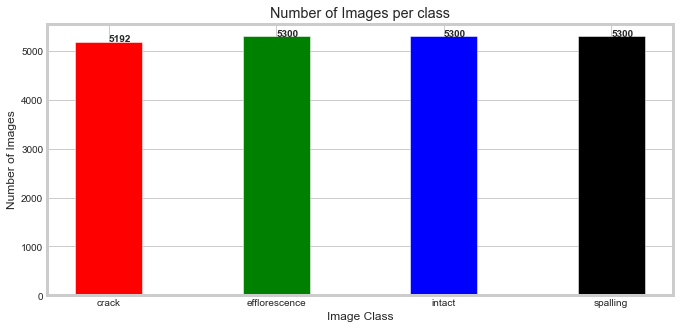

In [9]:
plot_image_data(image_count)

In [10]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()
df.tail()

(21092, 3)

,file,id,label
0,crack/000007.jpg,0,crack
1,crack/000056.jpg,0,crack
2,crack/000113.jpg,0,crack
3,crack/01.jpg,0,crack
4,crack/010.jpg,0,crack


,file,id,label
21087,spalling/995.jpg,3,spalling
21088,spalling/996.jpg,3,spalling
21089,spalling/997.jpg,3,spalling
21090,spalling/998.jpg,3,spalling
21091,spalling/999.jpg,3,spalling


### ONE HOT ENCODING

In [11]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'id' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['id']]).toarray())

#merge one-hot encoded columns back with original DataFrame
df = df.join(encoder_df)

df.drop('id', axis=1, inplace=True)

df.columns = ['file', 'label', 'crack', 'efflorescence', 'intact','spalling']

In [12]:
df.head()
df.tail()

,file,label,crack,efflorescence,intact,spalling
0,crack/000007.jpg,crack,1.0,0.0,0.0,0.0
1,crack/000056.jpg,crack,1.0,0.0,0.0,0.0
2,crack/000113.jpg,crack,1.0,0.0,0.0,0.0
3,crack/01.jpg,crack,1.0,0.0,0.0,0.0
4,crack/010.jpg,crack,1.0,0.0,0.0,0.0


,file,label,crack,efflorescence,intact,spalling
21087,spalling/995.jpg,spalling,0.0,0.0,0.0,1.0
21088,spalling/996.jpg,spalling,0.0,0.0,0.0,1.0
21089,spalling/997.jpg,spalling,0.0,0.0,0.0,1.0
21090,spalling/998.jpg,spalling,0.0,0.0,0.0,1.0
21091,spalling/999.jpg,spalling,0.0,0.0,0.0,1.0


### IMAGE PREPROCESSING

In [13]:
# function to get an image
def read_img(filepath, size,folder):
    path =os.path.join(folder, filepath);
    #print(f"filepath passed is: {filepath} and full path is: {path}")
    img = image.load_img(path, target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGES

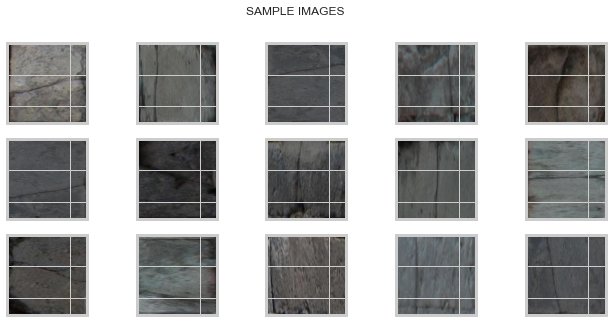

In [14]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255),train_folder))/255.);
plt.show();

### SHOW SAMPLE PROCESSED IMAGE


### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [15]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE),train_folder)/255.
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    X_train[i] = x

21092it [02:39, 132.55it/s]


In [16]:
# INPUT_SIZE=255
# X_train = np.zeros((1, INPUT_SIZE, INPUT_SIZE, 3), dtype='float')

# def batch_feature_extraction(start_index,end_index):
#     X_train_batch = np.zeros((1000, INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
#     for index in range(start_index,end_index):
#         diff=index-start_index
#         my_path = df.iloc[index,0]
#         print(f"{index} ",end=" ")
#         #print(f"file path is: {my_path}")
#         img = read_img(my_path,(INPUT_SIZE,INPUT_SIZE))
#         #masking and segmentation
#         image_segmented = segment_image(img)
#         #sharpen
#         image_sharpen = sharpen_image(image_segmented)
#         x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
#         #x = xception.preprocess_input(image_sharpen)
#         #X_train=np.append(X_train,[x],axis=0)
#         X_train_batch[diff]=x
#     return X_train_batch

In [17]:
# data_length = len(df)
# batch_size= 1000
# start_index=0
# end_index=0

# while start_index < data_length:
#     end_index=end_index+batch_size
#     end_index=end_index if end_index<data_length else data_length-1
#     print(f"start index is: {start_index} and end index is: {end_index}")
#     result=batch_feature_extraction(start_index,end_index)
#     X_train=np.append(X_train,result,axis=0)
#     start_index=end_index+1

In [18]:
#X_train = np.delete(X_train, (0), axis=0)

In [19]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (21092, 255, 255, 3)
Train Image Size:  4114521900


#### SPLIT THE DATA

In [20]:
y = df[['crack', 'efflorescence', 'intact','spalling']]
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [21]:
print('CRACK IMAGES ON TRAINING DATA: ',y['crack'].value_counts()[1])
print('EFFLORESCENCE IMAGES ON TRAINING DATA: ',y['efflorescence'].value_counts()[1])
print('INTACT IMAGES ON TRAINING DATA: ',y['intact'].value_counts()[1])
print('SPALLING IMAGES ON TRAINING DATA: ',y['spalling'].value_counts()[1])


CRACK IMAGES ON TRAINING DATA:  5192
EFFLORESCENCE IMAGES ON TRAINING DATA:  5300
INTACT IMAGES ON TRAINING DATA:  5300
SPALLING IMAGES ON TRAINING DATA:  5300


In [22]:
print(f"shapes are: {train_x.shape} {train_val.shape} {y_train.shape} {y_val.shape}")

shapes are: (16873, 255, 255, 3) (4219, 255, 255, 3) (16873, 4) (4219, 4)


In [23]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

132/132 [==============================] - 442s 3s/step


In [24]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (16873, 2048)
Train Size:  34555904
Validation Shape:  (4219, 2048)
Validation Size:  8640512


### DEEP LEARNING MODEL

In [25]:
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
#model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(units = 4, activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 541,252
Trainable params: 541,252
Non-trainable params: 0
_________________________________________________________________


In [26]:
#train the model @ 500 epochs
history = model.fit(bf_train_x, y_train, epochs=500, batch_size=32);

Epoch 1/500
528/528 [==============================] - 4s 4ms/step - loss: 1.3854 - accuracy: 0.2705
Epoch 2/500
528/528 [==============================] - 2s 4ms/step - loss: 1.2218 - accuracy: 0.4417
Epoch 3/500
528/528 [==============================] - 2s 4ms/step - loss: 1.1212 - accuracy: 0.5028
Epoch 4/500
528/528 [==============================] - 2s 4ms/step - loss: 1.1087 - accuracy: 0.5077
Epoch 5/500
528/528 [==============================] - 2s 4ms/step - loss: 1.1053 - accuracy: 0.5067
Epoch 6/500
528/528 [==============================] - 2s 4ms/step - loss: 1.0767 - accuracy: 0.5288
Epoch 7/500
528/528 [==============================] - 2s 5ms/step - loss: 1.0673 - accuracy: 0.5315
Epoch 8/500
528/528 [==============================] - 3s 5ms/step - loss: 1.0498 - accuracy: 0.5400
Epoch 9/500
528/528 [==============================] - 2s 4ms/step - loss: 1.0486 - accuracy: 0.5408
Epoch 10/500
528/528 [==============================] - 2s 4ms/step - loss: 1.0421 - accura

528/528 [==============================] - 3s 5ms/step - loss: 0.7168 - accuracy: 0.7090: 0s - loss: 0.7174 - accuracy - ETA: 0s - loss: 0.7194 - ac
Epoch 80/500
528/528 [==============================] - 2s 4ms/step - loss: 0.7151 - accuracy: 0.7105
Epoch 81/500
528/528 [==============================] - 2s 4ms/step - loss: 0.7157 - accuracy: 0.7097
Epoch 82/500
528/528 [==============================] - 2s 4ms/step - loss: 0.7072 - accuracy: 0.7105
Epoch 83/500
528/528 [==============================] - 2s 4ms/step - loss: 0.7116 - accuracy: 0.7077
Epoch 84/500
528/528 [==============================] - 2s 5ms/step - loss: 0.7121 - accuracy: 0.7100
Epoch 85/500
528/528 [==============================] - 3s 5ms/step - loss: 0.6936 - accuracy: 0.7163
Epoch 86/500
528/528 [==============================] - 3s 5ms/step - loss: 0.6957 - accuracy: 0.7164
Epoch 87/500
528/528 [==============================] - 2s 5ms/step - loss: 0.6968 - accuracy: 0.7150
Epoch 88/500
528/528 [=============

528/528 [==============================] - 2s 5ms/step - loss: 0.6265 - accuracy: 0.7472
Epoch 158/500
528/528 [==============================] - 2s 5ms/step - loss: 0.6220 - accuracy: 0.7491
Epoch 159/500
528/528 [==============================] - 2s 5ms/step - loss: 0.6165 - accuracy: 0.7513
Epoch 160/500
528/528 [==============================] - 2s 4ms/step - loss: 0.6138 - accuracy: 0.7542
Epoch 161/500
528/528 [==============================] - 2s 5ms/step - loss: 0.6146 - accuracy: 0.7531
Epoch 162/500
528/528 [==============================] - 2s 4ms/step - loss: 0.6026 - accuracy: 0.7571
Epoch 163/500
528/528 [==============================] - 2s 5ms/step - loss: 0.6150 - accuracy: 0.7544
Epoch 164/500
528/528 [==============================] - 3s 5ms/step - loss: 0.6127 - accuracy: 0.7554: 0s - loss: 0.6168 
Epoch 165/500
528/528 [==============================] - 2s 5ms/step - loss: 0.6122 - accuracy: 0.7529
Epoch 166/500
528/528 [==============================] - 2s 4ms/ste

528/528 [==============================] - 2s 5ms/step - loss: 0.5613 - accuracy: 0.7759
Epoch 235/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5845 - accuracy: 0.7681
Epoch 236/500
528/528 [==============================] - 3s 5ms/step - loss: 0.5815 - accuracy: 0.7686
Epoch 237/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5600 - accuracy: 0.7762
Epoch 238/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5721 - accuracy: 0.7747
Epoch 239/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5831 - accuracy: 0.7683
Epoch 240/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5643 - accuracy: 0.7769
Epoch 241/500
528/528 [==============================] - 3s 5ms/step - loss: 0.5644 - accuracy: 0.7749
Epoch 242/500
528/528 [==============================] - 3s 5ms/step - loss: 0.5695 - accuracy: 0.7757
Epoch 243/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5662 - a

528/528 [==============================] - 2s 5ms/step - loss: 0.5275 - accuracy: 0.7923
Epoch 313/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5500 - accuracy: 0.7860
Epoch 314/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5467 - accuracy: 0.7837
Epoch 315/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5265 - accuracy: 0.7947
Epoch 316/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5276 - accuracy: 0.7892
Epoch 317/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5344 - accuracy: 0.7919
Epoch 318/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5374 - accuracy: 0.7872
Epoch 319/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5340 - accuracy: 0.7908
Epoch 320/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5361 - accuracy: 0.7888
Epoch 321/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5344 - a

528/528 [==============================] - 2s 4ms/step - loss: 0.5321 - accuracy: 0.7903
Epoch 391/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5214 - accuracy: 0.7955
Epoch 392/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5027 - accuracy: 0.8013
Epoch 393/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5137 - accuracy: 0.7968
Epoch 394/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5069 - accuracy: 0.7999
Epoch 395/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5134 - accuracy: 0.7977
Epoch 396/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5101 - accuracy: 0.8018
Epoch 397/500
528/528 [==============================] - 2s 4ms/step - loss: 0.5099 - accuracy: 0.7986
Epoch 398/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5053 - accuracy: 0.7996
Epoch 399/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5088 - a

528/528 [==============================] - 3s 5ms/step - loss: 0.5081 - accuracy: 0.7999
Epoch 470/500
528/528 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.80 - 3s 5ms/step - loss: 0.4910 - accuracy: 0.8070
Epoch 471/500
528/528 [==============================] - 2s 5ms/step - loss: 0.5094 - accuracy: 0.7970
Epoch 472/500
528/528 [==============================] - 2s 4ms/step - loss: 0.4905 - accuracy: 0.8087
Epoch 473/500
528/528 [==============================] - 2s 4ms/step - loss: 0.4881 - accuracy: 0.8118
Epoch 474/500
528/528 [==============================] - 2s 4ms/step - loss: 0.4787 - accuracy: 0.8108
Epoch 475/500
528/528 [==============================] - 2s 5ms/step - loss: 0.4965 - accuracy: 0.8063
Epoch 476/500
528/528 [==============================] - 2s 5ms/step - loss: 0.4869 - accuracy: 0.8088
Epoch 477/500
528/528 [==============================] - 3s 5ms/step - loss: 0.4930 - accuracy: 0.8067
Epoch 478/500
528/528 [======================

#### LOSS AND ACCURACY

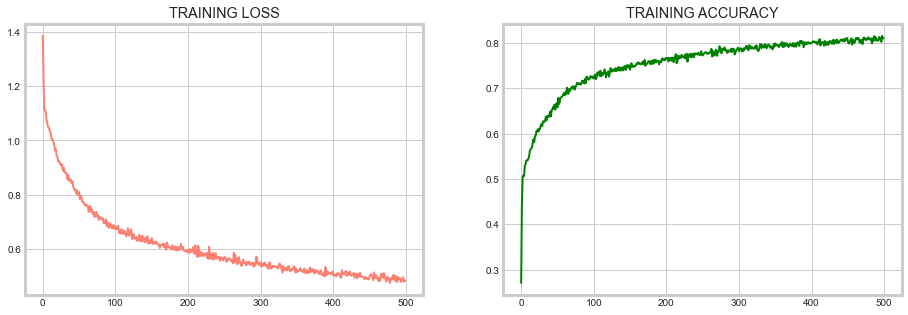

In [27]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [101]:
#predict the validation data
predictions = (model.predict(bf_train_val) > 0.5).astype("int32") #model.predict_classes(bf_train_val)

In [102]:
print(predictions)

[[0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]]


In [103]:
print(y_val)

       crack  efflorescence  intact  spalling
10118    0.0            1.0     0.0       0.0
16528    0.0            0.0     0.0       1.0
1552     1.0            0.0     0.0       0.0
17662    0.0            0.0     0.0       1.0
6744     0.0            1.0     0.0       0.0
...      ...            ...     ...       ...
5205     0.0            1.0     0.0       0.0
10453    0.0            1.0     0.0       0.0
21009    0.0            0.0     0.0       1.0
16385    0.0            0.0     0.0       1.0
21006    0.0            0.0     0.0       1.0

[4219 rows x 4 columns]


#### CLASSIFICATION REPORT

In [104]:
target_names=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING']
print(classification_report(y_val, predictions,target_names=target_names))

               precision    recall  f1-score   support

        CRACK       0.57      0.92      0.71      1077
EFFLORESCENSE       0.90      0.83      0.87      1079
       INTACT       0.96      0.47      0.63      1026
     SPALLING       0.87      0.61      0.72      1037

    micro avg       0.76      0.71      0.74      4219
    macro avg       0.83      0.71      0.73      4219
 weighted avg       0.83      0.71      0.73      4219
  samples avg       0.71      0.71      0.71      4219



C:\Users\RILLO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### CONFUSION MATRIX

[[1035    1    2   39]
 [ 131  896   13   39]
 [ 520   10  482   14]
 [ 314   84    5  634]]
shape of yval is: (4219, 4) and predictions shape is: (4219, 4)


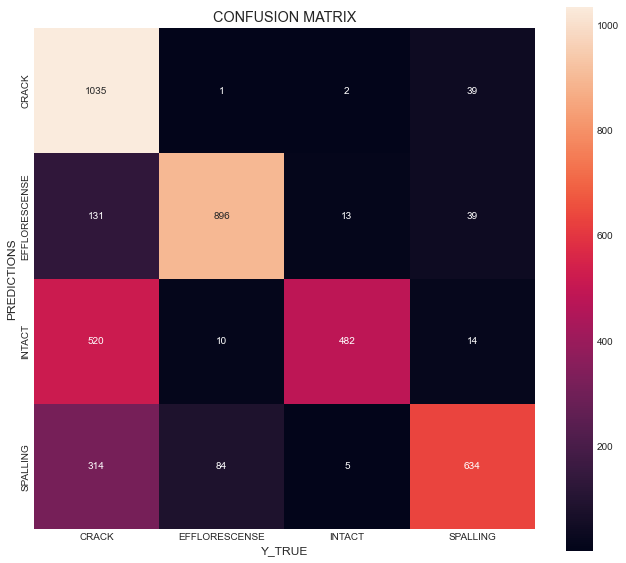

In [105]:
confusion_mat = confusion_matrix(y_val.values.argmax(axis=1), predictions.argmax(axis=1))
print(confusion_mat)
print(f"shape of yval is: {y_val.shape} and predictions shape is: {predictions.shape}")
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,fmt='g',
            yticklabels=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING'],
            xticklabels=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

In [127]:
from sklearn.metrics import accuracy_score
cnn_acc=accuracy_score(y_val, predictions)
print(f"Accuracy is: {cnn_acc*100}%")

Accuracy is: 71.24911116378289%


In [33]:
## SAVE MODEL

In [34]:
saved_model_dir = '../output/model/'
model_name = saved_model_dir+f"cnn_model_{dt.datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.h5"
print(f"model name is: {model_name}")
model.save(model_name)

model name is: ../output/model/cnn_model_08_11_2022_23_51_48.h5


<h1> SUPPORT VECTOR MACHINE

In [58]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
svm_model=svm.SVC(kernel='rbf', gamma=0.5, C=0.1)

<h3> CONVERT ONE_HOT ENCODED TO LABEL

In [80]:
y_train_svm=encoder.inverse_transform(y_train)
# 0---> crack
# 1---> efflorescence  
# 2---> intact  
# 3---> spalling
y_train_svm=y_train_svm.ravel()
print(y_train_svm)

[3 3 0 ... 3 3 2]


In [81]:
history=svm_model.fit(bf_train_x, y_train_svm)

In [109]:
#predict the validation data
svm_predictions = svm_model.predict(bf_train_val) 

In [110]:
def manual_hot_encode(array):
    hot_list=[]
    for arr in array:
        temp=[0,0,0,0]
        temp[arr]=1
        hot_list.append(temp)
    return np.array(hot_list)
            

In [111]:
print(svm_predictions)
svm_predictions.reshape(1, -1) 
svm_predictions = manual_hot_encode(svm_predictions)
print(svm_predictions)

[1 3 3 ... 2 3 3]


array([[1, 3, 3, ..., 2, 3, 3]], dtype=int64)

[[0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]]


In [112]:
print(y_val)

       crack  efflorescence  intact  spalling
10118    0.0            1.0     0.0       0.0
16528    0.0            0.0     0.0       1.0
1552     1.0            0.0     0.0       0.0
17662    0.0            0.0     0.0       1.0
6744     0.0            1.0     0.0       0.0
...      ...            ...     ...       ...
5205     0.0            1.0     0.0       0.0
10453    0.0            1.0     0.0       0.0
21009    0.0            0.0     0.0       1.0
16385    0.0            0.0     0.0       1.0
21006    0.0            0.0     0.0       1.0

[4219 rows x 4 columns]


#### CLASSIFICATION REPORT

In [113]:
print(classification_report(y_val, svm_predictions))

              precision    recall  f1-score   support

           0       0.56      0.02      0.04      1077
           1       0.74      0.56      0.64      1079
           2       0.46      0.83      0.59      1026
           3       0.42      0.62      0.50      1037

   micro avg       0.50      0.50      0.50      4219
   macro avg       0.55      0.51      0.44      4219
weighted avg       0.55      0.50      0.44      4219
 samples avg       0.50      0.50      0.50      4219



#### CONFUSION MATRIX

[[ 22 127 508 420]
 [ 10 601 163 305]
 [  6  10 848 162]
 [  1  74 319 643]]
shape of yval is: (4219, 4) and predictions shape is: (4219, 4)


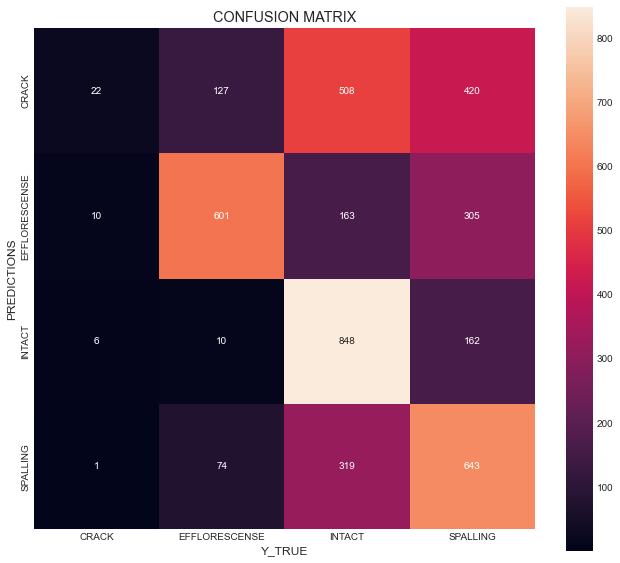

In [114]:
confusion_mat = confusion_matrix(y_val.values.argmax(axis=1), svm_predictions.argmax(axis=1))
print(confusion_mat)
print(f"shape of yval is: {y_val.shape} and predictions shape is: {svm_predictions.shape}")
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,fmt='g',
            yticklabels=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING'],
            xticklabels=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

In [116]:
from sklearn.metrics import accuracy_score
svm_acc=accuracy_score(y_val, svm_predictions)
print(f"Accuracy is: {svm_acc*100}%")

Accuracy is: 50.106660346053566%


<h1> NAIVE BAYES

In [117]:
# import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB




In [118]:
# create a Gaussian Classifier
naive_model = GaussianNB()

In [119]:
y_train_naive= y_train_svm

In [120]:
# training the model
history=naive_model.fit(bf_train_x, y_train_naive)

In [121]:
#predict the validation data
naive_predictions = naive_model.predict(bf_train_val) 

In [122]:
print(naive_predictions)
naive_predictions.reshape(1, -1) 
naive_predictions = manual_hot_encode(naive_predictions)
print(naive_predictions)

[1 3 3 ... 3 3 3]


array([[1, 3, 3, ..., 3, 3, 3]], dtype=int64)

[[0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [123]:
print(y_val)

       crack  efflorescence  intact  spalling
10118    0.0            1.0     0.0       0.0
16528    0.0            0.0     0.0       1.0
1552     1.0            0.0     0.0       0.0
17662    0.0            0.0     0.0       1.0
6744     0.0            1.0     0.0       0.0
...      ...            ...     ...       ...
5205     0.0            1.0     0.0       0.0
10453    0.0            1.0     0.0       0.0
21009    0.0            0.0     0.0       1.0
16385    0.0            0.0     0.0       1.0
21006    0.0            0.0     0.0       1.0

[4219 rows x 4 columns]


In [124]:
print(classification_report(y_val, naive_predictions))

              precision    recall  f1-score   support

           0       0.46      0.22      0.30      1077
           1       0.78      0.42      0.55      1079
           2       0.80      0.23      0.36      1026
           3       0.35      0.94      0.51      1037

   micro avg       0.45      0.45      0.45      4219
   macro avg       0.60      0.45      0.43      4219
weighted avg       0.60      0.45      0.43      4219
 samples avg       0.45      0.45      0.45      4219



[[238  91  41 707]
 [158 455  16 450]
 [ 94   9 238 685]
 [ 32  27   3 975]]
shape of yval is: (4219, 4) and predictions shape is: (4219, 4)


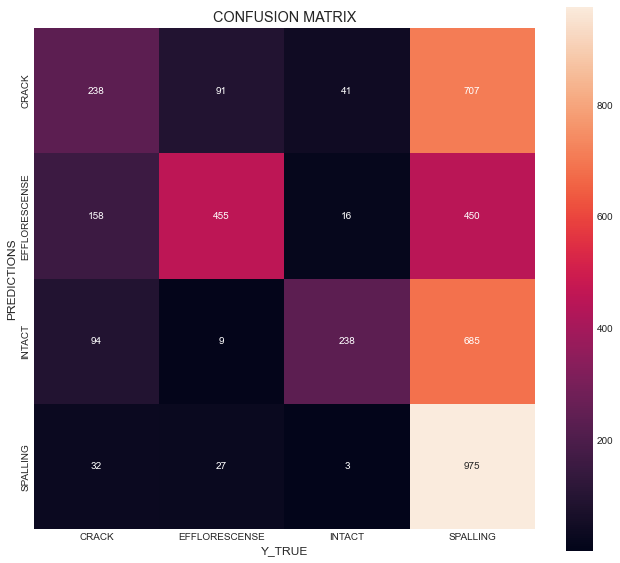

In [125]:
confusion_mat = confusion_matrix(y_val.values.argmax(axis=1), naive_predictions.argmax(axis=1))
print(confusion_mat)
print(f"shape of yval is: {y_val.shape} and predictions shape is: {naive_predictions.shape}")
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,fmt='g',
            yticklabels=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING'],
            xticklabels=['CRACK', 'EFFLORESCENSE', 'INTACT','SPALLING']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

In [126]:
from sklearn.metrics import accuracy_score
naive_acc=accuracy_score(y_val, naive_predictions)
print(f"Accuracy is: {naive_acc*100}%")

Accuracy is: 45.176582128466464%


<h1> COMPARE RESULT

In [134]:
def plot_accuracies(accuracies):
    plt_val=[]
    plt_key=[]
    for model,accuracy in accuracies.items():
        print('{0} -> {1}'.format(model, accuracy))
        accuracy=round(accuracy,4)
        plt_val.append(accuracy*100)
        plt_key.append(model)
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    colors= list('rgbkymc')
    plt.bar(plt_key, plt_val, color =colors,
            width = 0.4)
    plt.ylabel("Accuracy Values")
    plt.xlabel("Model Type")
    plt.title("Accuracy per Model")
    for index, value in enumerate(plt_val):
        plt.text(index, value,
                 str(value), fontweight = 'bold')
    plt.show()

CNN -> 0.7124911116378289
SVM -> 0.5010666034605357
NAIVE_BAYE -> 0.45176582128466464


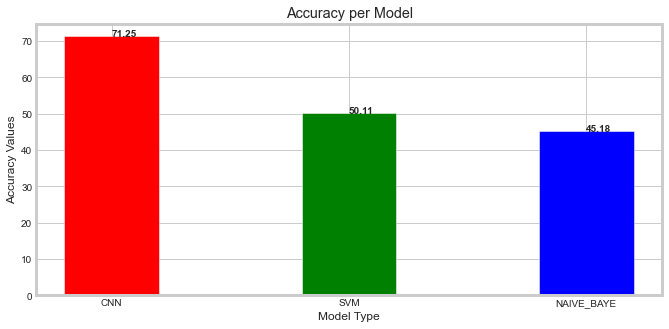

In [135]:
accuracies={"CNN":cnn_acc,"SVM":svm_acc,"NAIVE_BAYE":naive_acc}
plot_accuracies(accuracies)